In [1]:
import sys, os, pygmt
sys.path.insert(0, '/home/581/da1339/AFIM/src/AFIM/src')
from sea_ice_processor          import SeaIceProcessor
from sea_ice_plotter            import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor
from datetime                   import timedelta, date, datetime
from pathlib                    import Path
from dask.distributed           import Client, LocalCluster
import numpy                    as np
import pandas                   as pd
import xarray                   as xr
import xesmf                    as xe
import matplotlib.pyplot        as plt
import matplotlib.dates         as mdates

In [62]:
import sys
import importlib
# Add your local module path only once
mod_path = '/home/581/da1339/AFIM/src/AFIM/src'
if mod_path not in sys.path:
    sys.path.insert(0, mod_path)
# Import module *objects* first
import sea_ice_processor
import sea_ice_plotter
import grounded_iceberg_processor
# Reload them if they were edited
importlib.reload(sea_ice_processor)
importlib.reload(sea_ice_plotter)
importlib.reload(grounded_iceberg_processor)
# Then (re)import the classes from the reloaded modules
from sea_ice_processor import SeaIceProcessor
from sea_ice_plotter import SeaIcePlotter
from grounded_iceberg_processor import GroundedIcebergProcessor

# grounded icebergs

In [57]:
GI_proc = GroundedIcebergProcessor()
GI_proc.process_raw_grounded_iceberg_database()
GI_proc.modify_landmask_with_grounded_icebergs(p_min=0.1, p_max=0.9, scaling_exponent=.35)

Simulation name not provided. Class assumes you are creating new landmask for sea ice modelling.


In [59]:
GI_proc.write_modified_landmask_and_counts_to_disk(write=True, overwrite=True)

modified KMT     : /g/data/gv90/da1339/grounded_icebergs/MyThin_db/GI_thinned-0p60_v1p50.nc
thinned GI count : /g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p60_v1p50.nc
Modified KMT and GI-count-file do not exist. Writing out the above files


In [ ]:
SP = SeaIcePlotter(ice_type='GI', sim_name='baseline', show_fig = True, save_fig = True, )
KMT1 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50_POSSIBLE_ERROR.nc")
KMT2 = xr.open_dataset("/g/data/gv90/da1339/grounded_icebergs/MyThin_db/kmt_mod_thinned-0p75_v1p50.nc")
SP.plot_sectors_grounded_icebergs(KMT2=KMT2,save_dir="0p25", filename_extras="POSSIBLE-ERRORS_v_Revised")

# process for fast ice using SeaIceProcessor()

In [ ]:
FIP_comp  = {}
FIA_comp  = {}
sim_names = ['baseline','gi-min','gi-min-elps-def','gi-max', 'gi-mid']
for sim_name in sim_names:
    SI_proc            = SeaIceProcessor(sim_name=sim_name)
    FI                 = SI_proc.load_raw_ice_type(ice_type="FI")
    FI_bool            = SI_proc.boolean_fast_ice(FI['mask']).persist()
    FIC                = FI['aice'].where(FI_bool).persist()
    GC_area            = FI['uarea'].where(FI_bool).persist()
    FIP_comp[sim_name] = SI_proc.compute_variable_aggregate(FIC).compute()
    FIA_comp[sim_name] = SI_proc.compute_ice_area(FIC,GC_area).compute()

2025-05-15 05:33:42,215 - INFO - log file intialised: /g/data/gv90/da1339/logs/SeaIceProcessor_FI_baseline.log
2025-05-15 05:34:08,078 - INFO - hemisphere initialised: south
INFO:baseline:hemisphere initialised: south
2025-05-15 05:34:30,003 - INFO - ✅ New Dask client created with 56 workers
INFO:baseline:✅ New Dask client created with 56 workers
2025-05-15 05:34:30,007 - INFO - 📂 Loading all monthly FI Zarr datasets
INFO:baseline:📂 Loading all monthly FI Zarr datasets
2025-05-15 05:35:39,900 - INFO - 🔁 Reshaping 'uarea' to match 'aice'
INFO:baseline:🔁 Reshaping 'uarea' to match 'aice'
2025-05-15 05:35:39,904 - INFO - 🔁 Rolling boolean presence: window = 7, min_count = 5
INFO:baseline:🔁 Rolling boolean presence: window = 7, min_count = 5
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 20.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using fu

plot path: /g/data/gv90/da1339/GRAPHICAL/AFIM/faceted/FIP/FIP_faceted.png
working on simulation: baseline
working on region: EIO


INFO:pyogrio._io:Created 357 records


working on simulation: gi-min
working on region: EIO


INFO:pyogrio._io:Created 357 records


working on simulation: gi-min-elps-def
working on region: EIO


INFO:pyogrio._io:Created 357 records


working on simulation: gi-max
working on region: EIO


INFO:pyogrio._io:Created 357 records


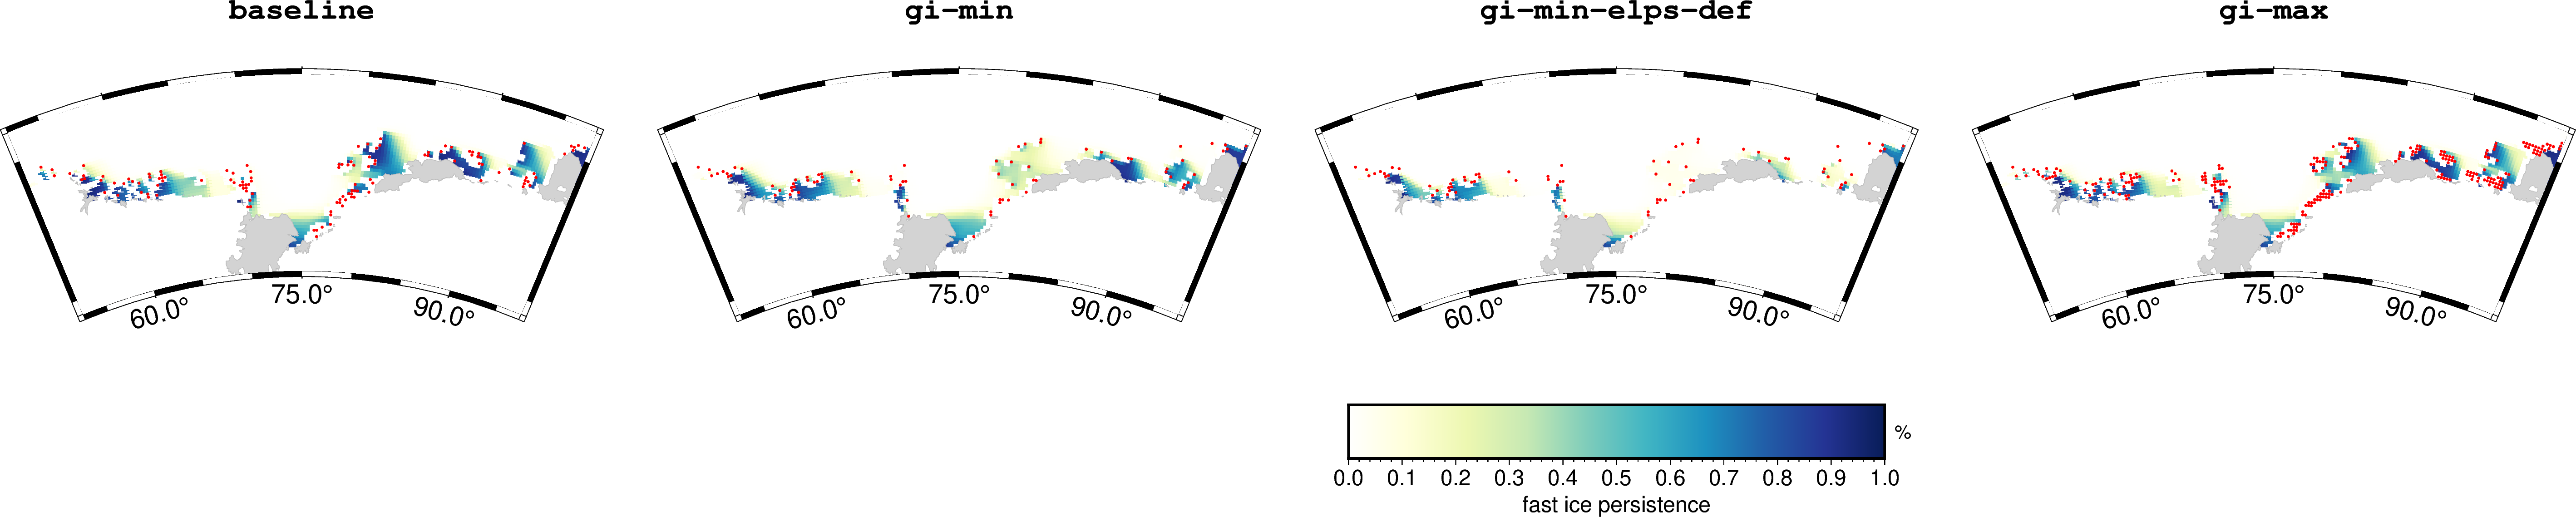

figure saved: /g/data/gv90/da1339/GRAPHICAL/AFIM/faceted/FIP/FIP_faceted.png
time taken 14.31 seconds



In [38]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'aggregate',
                        var_name  = 'FIP',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
plotter.plot_facet_regions( da_dict = FIP_comp , figure_size = ("60c","6c"), panel_margins="0.25c", cbar_position="JBC+w40c/1c+h")

💾 Saved plot to /g/data/gv90/da1339/GRAPHICAL/timeseries/FIA_GI-comp_boolean-method_15day-smooth_1993-1999.png


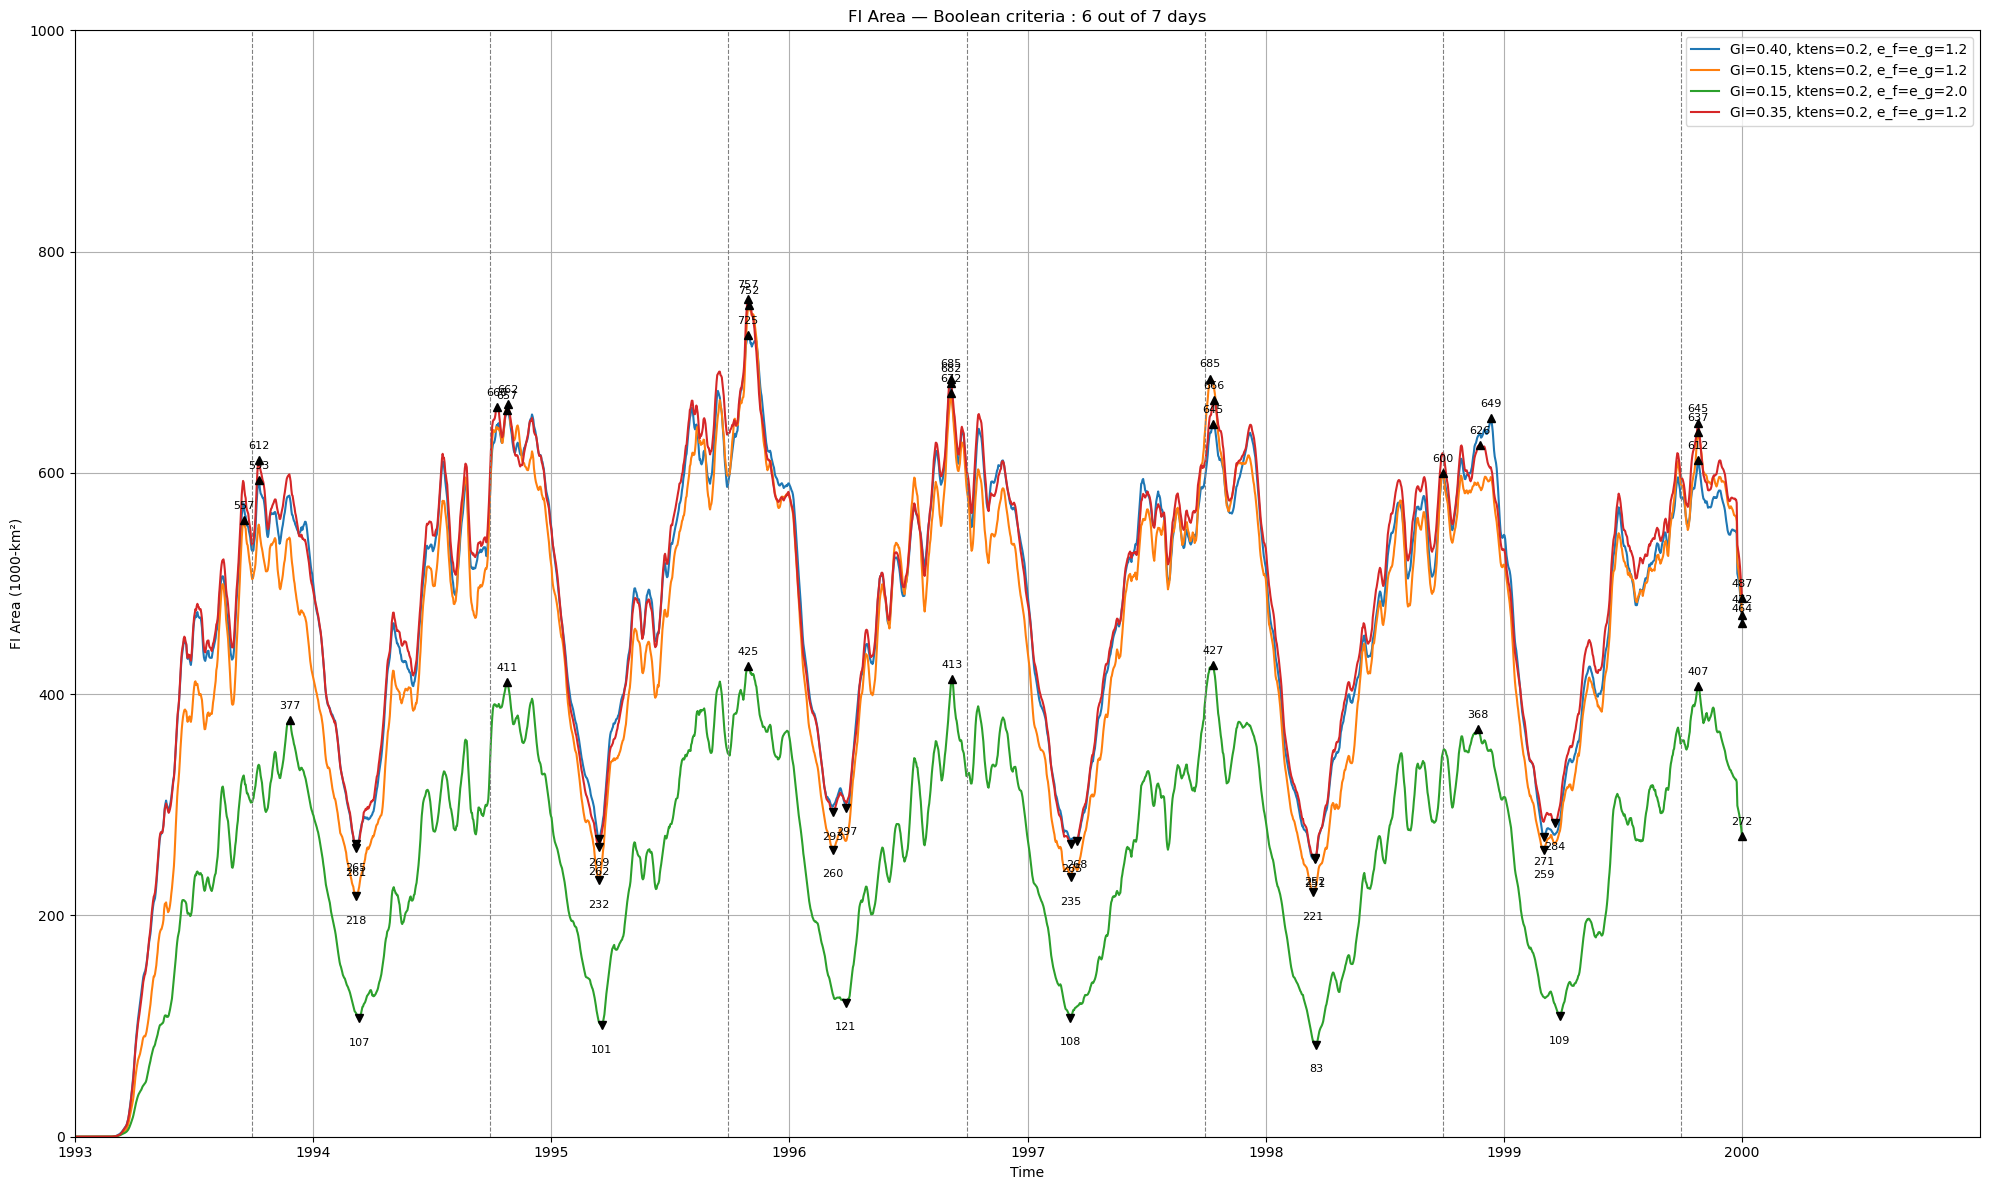

In [3]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'timeseries',
                        var_name  = 'FIA',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
plotter.plot_ice_area(FIA_comp, roll_days=15, 
                      P_png=os.path.join(plotter.config['D_dict']['graph'],'timeseries','FIA_GI-comp_boolean-method_15day-smooth_1993-1999.png'))

In [4]:
FIP_comp2  = {}
FIA_comp2  = {}
sim_names = ['baseline','gi-min','gi-min-elps-def','gi-max']
for sim_name in sim_names:
    SI_proc            = SeaIceProcessor(sim_name=sim_name)
    SI                 = SI_proc.load_raw_ice_type(ice_type="SI")
    SI_roll            = SI_proc.compute_rolling_mean_on_dataset(SI)
    sic_mask           = SI_roll['aice'] > SI_proc.icon_thresh
    ispd_mask          = (SI_roll['ispd'] >= SI_proc.ispd_lo_thresh) & (SI_roll['ispd'] <= SI_proc.ispd_hi_thresh)
    FI_mask            = sic_mask & ispd_mask
    FI_bool            = SI_proc.boolean_fast_ice(FI_mask).persist()
    FIC                = FI['aice'].where(FI_bool).persist()
    GC_area            = FI['uarea'].where(FI_bool).persist()
    FIP_comp2[sim_name] = SI_proc.compute_variable_aggregate(FIC).compute()
    FIA_comp2[sim_name] = SI_proc.compute_ice_area(FIC,GC_area).compute()

2025-05-14 18:38:58,141 - INFO - hemisphere initialised: south
INFO:baseline:hemisphere initialised: south
2025-05-14 18:38:58,158 - INFO - ✅ Using existing Dask client with 56 workers
INFO:baseline:✅ Using existing Dask client with 56 workers
2025-05-14 18:38:58,160 - WARNING - ⚠️ Unknown ice_type 'SI' — reverting to 'FI'
2025-05-14 18:38:58,163 - INFO - 📂 Loading all monthly SI Zarr datasets
INFO:baseline:📂 Loading all monthly SI Zarr datasets
2025-05-14 18:39:30,237 - INFO - 🔁 Reshaping 'uarea' to match 'aice'
INFO:baseline:🔁 Reshaping 'uarea' to match 'aice'
2025-05-14 18:39:30,540 - INFO - 🔁 Rolling boolean presence: window = 7, min_count = 5
INFO:baseline:🔁 Rolling boolean presence: window = 7, min_count = 5
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.07/lib/python3.10/site-packages/distributed/client.py:3371: UserWarning: Sending large graph of size 31.71 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects

💾 Saved plot to /g/data/gv90/da1339/GRAPHICAL/timeseries/FIA_GI-comp_average-first_boolean-method_15day-smooth_1993-1999.png


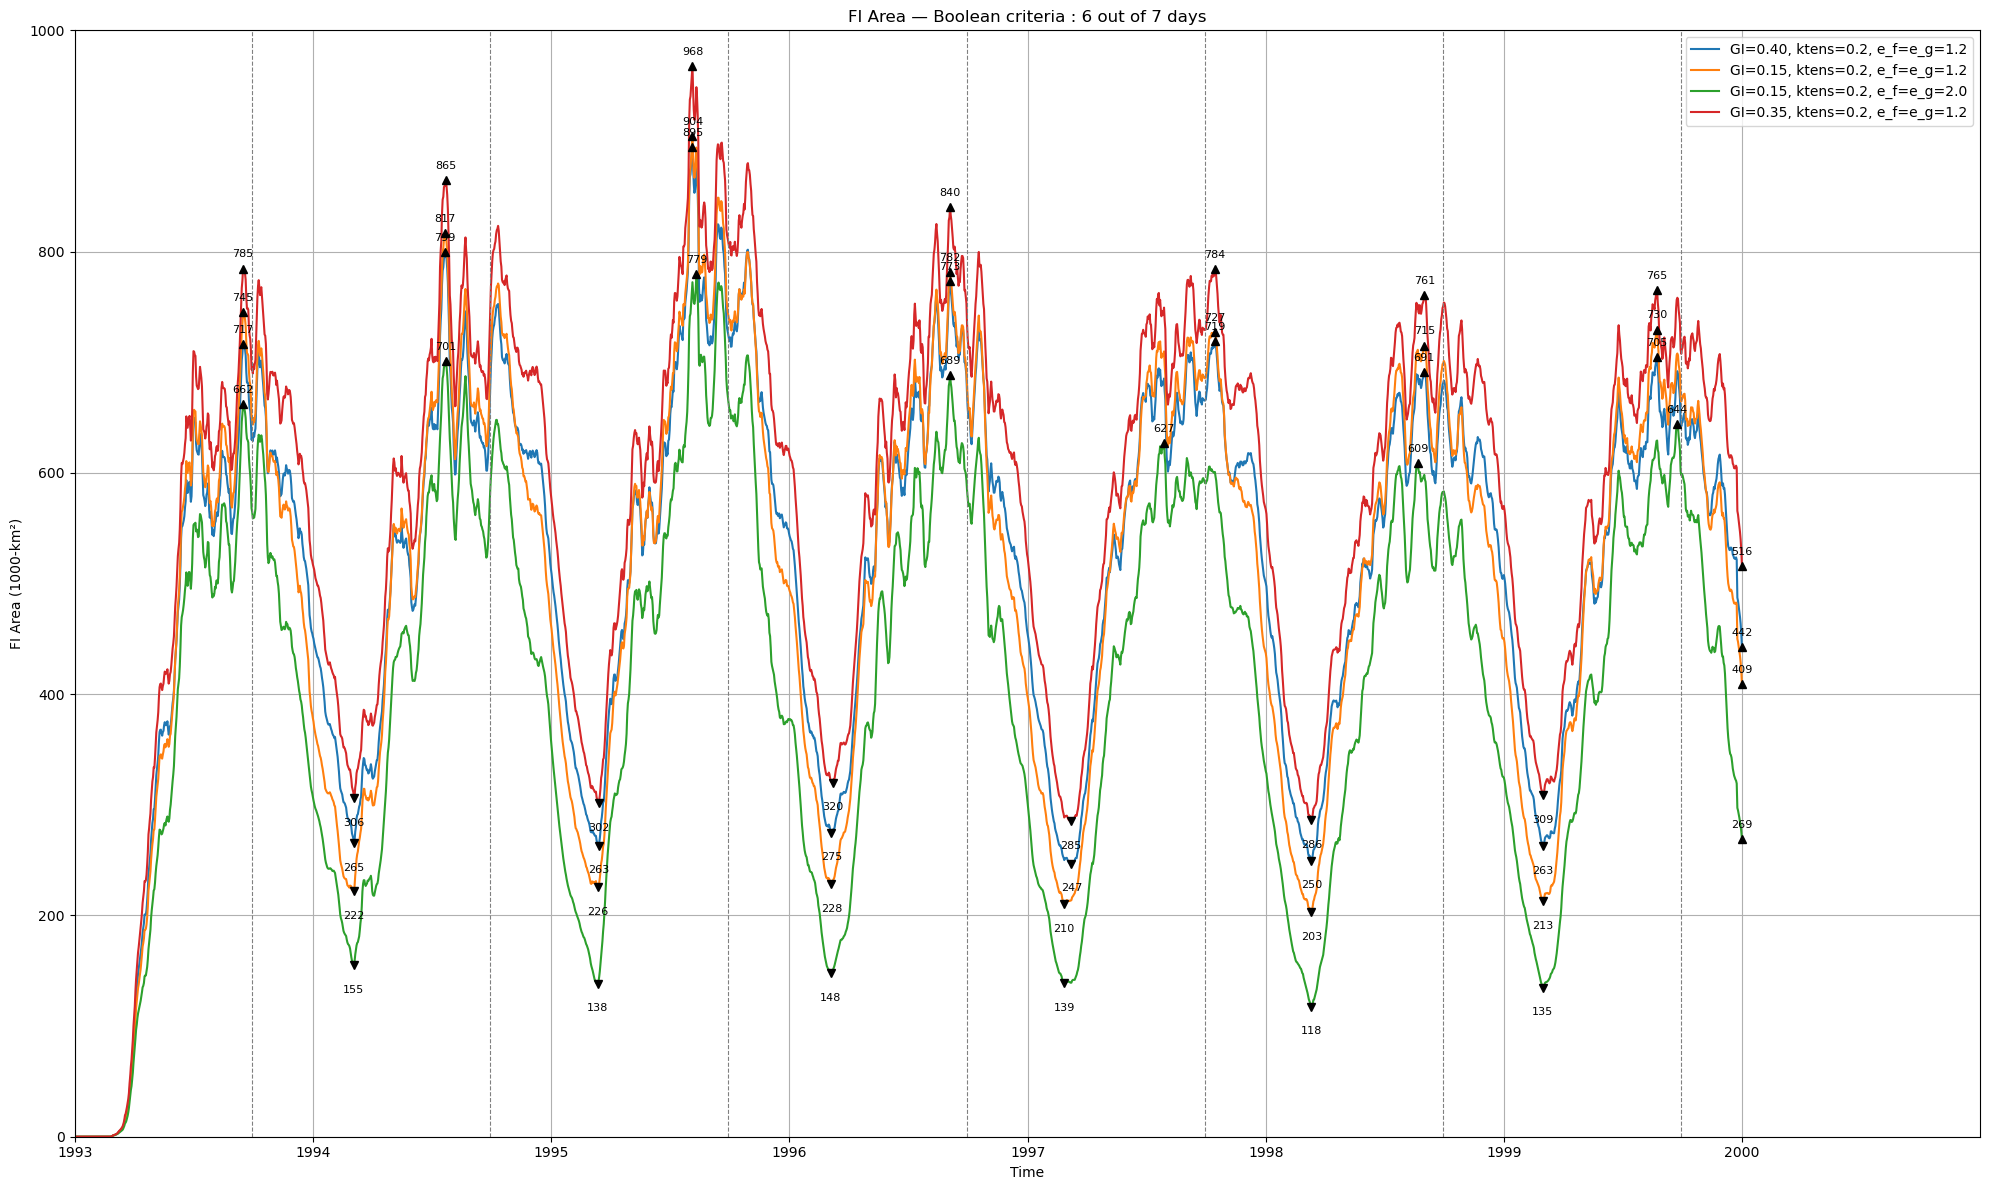

In [5]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'timeseries',
                        var_name  = 'FIA',
                        show_fig  = True,
                        save_fig  = True,
                        overwrite = True)
plotter.plot_ice_area(FIA_comp2, roll_days=15, 
                      P_png=os.path.join(plotter.config['D_dict']['graph'],'timeseries','FIA_GI-comp_average-first_boolean-method_15day-smooth_1993-1999.png'))

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIC',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( FI_div, "FIC" , region_name="EIO" , time_coordinate_name='t_dim', **options)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIC_4D',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( FI_div, "FIC_4D" , region_name="EIO" , time_coordinate_name='time', **options)

## re-work fast ice classification

In [ ]:
sim_name       = 'gi-min'
year           = 1998
win            = 15
bool_win       = 6
bool_min       = 4
ispd_thresh    = 1.0e-3
aice_thresh    = 0.15
SO_slice       = slice(0,540)
nj_slice       = slice(130,150)
ni_slice       = slice(100,200)

In [ ]:
### interpreting ice speed threshold in terms of physical displacement over time, relative to the grid resolution
m_per_day = ispd_thresh * 86400
print(f"ice displacement in meters per day with a given ice speed threshold of {ispd_thresh:0.1e} m/s = {m_per_day:0.1f} meters")
G_res        = 0.25
m_per_deg_eq = 111*1e3
GC_len_eq    = G_res * m_per_deg_eq
GC_len_ant   = GC_len_eq * np.cos(-70) #average latitude of Antarctic coastline
pct_GC_disp  = m_per_day / GC_len_ant
days_per_GC  = GC_len_ant / m_per_day
print(f"percent of grid cell displacement per day is {pct_GC_disp*100:0.3f}% based on above ice speed threshold")
print(f"or at the rate of {ispd_thresh:0.1e} (m/s) it would take {days_per_GC:0.1f} days for ice to completely replaced by displacement alone")

### fast ice area

In [ ]:
aice_FI = FI_DS['aice'].chunk({'time':win})
FIA_results = {}
print("computing raw")
FIA_results['raw']  = (((aice_FI * grid_cell_area).sum(dim=('nj', 'ni')) / 1e9)+SI_proc.GI_total_area).compute()
print("computing raw smooth")
FIA_results['mean'] = (FIA_results['raw'].rolling(time=win, center=True, min_periods=1).mean()).compute()

In [ ]:
print("putting data into a dataframe")
df = pd.DataFrame({'time'    : FIA_results['raw'].time.values,
                   'raw'     : FIA_results['raw'].compute(),
                   'mean'    : FIA_results['mean'].compute(),
                   'boolean' : FIA_bool.compute()})
df.set_index('time', inplace=True)

In [ ]:
plt.figure(figsize=(20,12))
time = np.arange(np.datetime64('1993-01-01'), np.datetime64('2000-01-01'))
plt.plot(time, df['raw']    , label='no mean')
plt.plot(time, df['mean']   , label='rolling mean')
plt.plot(time, df['boolean'], label='boolean method')
# Add vertical gridlines for each 30 Sep
sep30s = pd.date_range(start=time.min(), end=time.max(), freq='YE-SEP')
for dt in sep30s:
    plt.axvline(dt, color='gray', linestyle='--', linewidth=0.8)
years = list(range(pd.Timestamp(time.min()).year, pd.Timestamp(time.max()).year + 1))
for i, year in enumerate(years):
    yr_mask = (df.index.year == year)
    for label, series in df.items():
        # Skip 'raw' annotations completely
        if label == 'raw':
            continue
        subset = series[yr_mask].dropna()
        if subset.empty:
            continue
        # Max
        dt_max = subset.idxmax()
        val_max = subset.max()
        plt.plot(dt_max, val_max, marker='^', color='black')
        plt.text(dt_max, val_max + 10, f'{val_max:.0f}', ha='center', fontsize=8)
        # Min — but skip first and last year
        if i == 0 or i == len(years) - 1:
            continue
        dt_min = subset.idxmin()
        val_min = subset.min()
        plt.plot(dt_min, val_min, marker='v', color='black')
        plt.text(dt_min, val_min - 25, f'{val_min:.0f}', ha='center', fontsize=8)
# Labels and styling
plt.title(f"FIA Masking First → Then Averaging\nISP Threshold = {ispd_thresh:.1e}, Window = {win} days, Boolean window = {bool_win:d} days & min-days = {bool_min:d} ")
plt.ylabel("Fast Ice Area (1000-km²)")
plt.xlabel("Time")
plt.grid(True)
plt.ylim([100, 1200])
start_year = pd.Timestamp(time.min()).year
end_year   = pd.Timestamp(time.max()).year
plt.xlim(pd.Timestamp(f"{start_year}-01-01"), pd.Timestamp(f"{end_year}-12-31"))
plt.legend()
plt.tight_layout()
plt.show()

### spatial maps

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO/SO_1993-03.zarr", engine="zarr")
ds

In [ ]:
D_fi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/FI")
D_pi     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/PI")
D_so     = Path("/g/data/gv90/da1339/afim_output/gi-min/zarr/SO")
P_zarrs  = sorted(D_fi.glob("FI_*.zarr"))
months   = [f.stem.split("_")[1] for f in P_zarrs]  # e.g. "1993-01", "1993-02"
plt_vars = ['ispd', 'aice', 'hi', 'divu']
for yr_mo_str in months:
    FI_zarr = Path(D_fi,f"FI_{yr_mo_str}.zarr")
    PI_zarr = Path(D_pi,f"PI_{yr_mo_str}.zarr")
    SO_zarr = Path(D_so,f"SO_{yr_mo_str}.zarr")
    if not FI_zarr.exists() or not PI_zarr.exists() or not SO_zarr.exists():
        print(f"⚠️ Missing one or all datasets for {yr_mo_str}")
        continue
    #FI_DS = xr.open_zarr(FI_zarr)
    #PI_DS = xr.open_zarr(PI_zarr)
    SO_DS = xr.open_zarr(SO_zarr)
    # Parse start and end of the month
    dt_start        = pd.Timestamp(f"{yr_mo_str}-01")
    dt_end          = dt_start + pd.offsets.MonthEnd(0)
    yr_mo_start_str = dt_start.strftime("%Y-%m-%d")
    yr_mo_end_str   = dt_end.strftime("%Y-%m-%d")
    plotter         = SeaIcePlotter(sim_name   = sim_name,
                                    ice_type   = 'SI',
                                    plot_type  = 'regional',
                                    hemisphere = 'south',
                                    save_fig   = True,
                                    show_fig   = False,
                                    overwrite  = True)
    #for var in plt_vars:
    var = 'ispd'
    if var not in SO_DS:
        print(f"⚠️ Skipping {var}: not found in dataset for {yr_mo_str}")
        continue
    print(f"📡 Plotting {var} for {yr_mo_str}")
    extra_kwargs = {}
    if var == "aice":
        extra_kwargs = {"cmap": "viridis", "series": [0.9, 1], "cmap_reverse": True}
    elif var == "divu":
        extra_kwargs = {"cmap": "mag", "series": [-10, 10], "cmap_reverse": False}
    plotter.plot_map(ds              = SO_DS,
                     var_name        = var,
                     ispd_thresh     = ispd_thresh,
                     #ds_back         = PI_DS,
                     #var_name_back   = "ispd",
                     dt0_str         = yr_mo_start_str,
                     dtN_str         = yr_mo_end_str,
                     single_figure   = False,
                     #title_extras    = f"ispd_thresh = {ispd_thresh:.1e} m/s",
                     time_coord_name = "time",
                     lon_coord_name  = "TLON",
                     lat_coord_name  = "TLAT",
                     **extra_kwargs)

In [ ]:
# --- Parameters ---
win = 15
ispd_thresh = 5.e-4
year_str = "1998"
var_list = ['aice', 'hi', 'divu']

# --- Load and prepare fields ---
print("slicing")
CICE_SO = CICE.isel(nj=slice(0, 540)).copy()
uvel = CICE_SO['uvel']
vvel = CICE_SO['vvel']
ispd = np.sqrt(uvel**2 + vvel**2)
CICE_SO['ispd'] = ispd

# --- Apply centered mean ---
print("averaging")
CICE_smoothed = CICE_SO.rolling(time=win, center=True, min_periods=1).construct("window_dim").quantile(0.5, dim="window_dim")

# --- Fast Ice Masking THEN Centered Mean ---
print("masking")
sic_mask = CICE_smoothed['aice'] > 0.15
spd_mask = CICE_smoothed['ispd'] <= ispd_thresh
FI_mask = sic_mask & spd_mask
CICE_FI_masked = CICE_smoothed.where(FI_mask)

# --- Plot each variable ---
for var in var_list:
    if var not in CICE_smoothed:
        print(f"⚠️ Skipping {var}: not found in smoothed dataset.")
        continue
    print(f"📡 Plotting: {var}")
    extra_kwargs = {}
    if var=="aice":
        extra_kwargs = {"cmap"         : "viridis",
                        "series"       : [0.9, 1],
                        "cmap_reverse" : True}
    elif var=="divu":
        extra_kwargs = {"cmap"         : "mag",
                        "series"       : [-10,10],
                        "cmap_reverse" : False} if var == "divu" else {}
    print(extra_kwargs)
    plotter.plot_map(
        ds=CICE_FI_masked,
        var_name=var,
        dt0_str=f"{year_str}-09-01",
        dtN_str=f"{year_str}-10-31",
        single_figure=False,
        region_name='EIO',  # Or use 'Weddell', 'Amundsen', etc.
        time_coord_name="time",
        lon_coord_name="TLON",
        lat_coord_name="TLAT",
        **extra_kwargs
    )

# process sea ice

In [ ]:
SI_proc  = SeaIceProcessor(sim_name = sim_name,
                           sea_ice  = True)
SI_base = SI_proc.process_window(dt0_str   = dt0_str,
                                dtN_str    = dtN_str, 
                                write_zarr = False,
                                ow_zarrs   = False)

In [ ]:
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'SI',
                        plot_type = 'regional',
                        var_name  = 'SI_SPEED',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
options = {'sq_size_GI' : 0.1 }
plotter.animate_over_time( SI_base, "SI_SPEED" , region_name="EIO" , time_coordinate_name='t_dim', **options)

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/elps-def/history/daily/iceh.1994-09-*.nc", engine="netcdf")


In [ ]:
ds.uvel.isel(time=0,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
ds.aice.isel(time=5,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=0,vmax=1)

In [ ]:
for i in range(29):
    ds.uvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.uvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

In [ ]:
for i in range(29):
    ds.vvel.isel(time=i,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=1,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=2,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=3,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")
# ds.vvel.isel(time=4,nj=slice(100,200),ni=slice(1300,1440)).plot(figsize=(30,15),vmin=-.5,vmax=.5,cmap="RdBu")

# plot 1D analysis

In [ ]:
sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
time = pd.to_datetime(ds['t_dim'].values)
fia = ds['FIA']
fia_obs = ds['FIA_OBS'].sel(sector='circumpolar')
# --- Model: Monthly cycle by year ---
fia_df = pd.DataFrame({'FIA': fia.values}, index=time)
fia_df['Year'] = fia_df.index.year
fia_df['Month'] = fia_df.index.month
monthly_fia = fia_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_fia.pivot(index='Month', columns='Year', values='FIA')
# --- Obs: Monthly climatology (mean over available time) ---
# If FIA_OBS is already time-averaged, we assume it has a 12-month length
obs_df = fia_obs.to_dataframe().dropna().reset_index()
# Try parsing month info from the time (or fallback if no datetime index)
if 't_dim' in obs_df.columns and np.issubdtype(obs_df['t_dim'].dtype, np.datetime64):
    obs_df['Month'] = obs_df['t_dim'].dt.month
elif 'Month' not in obs_df.columns:
    obs_df['Month'] = range(1, len(obs_df)+1)
monthly_obs = obs_df.groupby('Month')['FIA_OBS'].mean()

# --- Plot ---
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')

# Plot each year from model
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)

# Plot observed climatology
plt.plot(monthly_obs.index, monthly_obs.values, label='Observed FIA (AF2020db)', 
         color='black', linestyle='--', linewidth=3)

plt.title("Monthly Fast Ice Area Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Area ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_FIA_grouped_by_month.png")

In [ ]:
# sim_name = 'baseline'
ds = xr.open_mfdataset(f"/g/data/gv90/da1339/afim_output/{sim_name}/FI/fast_ice_199*.zarr", engine='zarr')
var_name = 'FIV'
# Convert time to datetime index
time = pd.to_datetime(ds['t_dim'].values)
plot_da = ds[var_name]/1e12
# --- Model: Monthly cycle by year ---
plot_df = pd.DataFrame({var_name: plot_da.values}, index=time)
plot_df['Year'] = plot_df.index.year
plot_df['Month'] = plot_df.index.month
monthly_plot = plot_df.groupby(['Year', 'Month']).mean().reset_index()
monthly_cycle = monthly_plot.pivot(index='Month', columns='Year', values=var_name)
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
for year in monthly_cycle.columns:
    plt.plot(monthly_cycle.index, monthly_cycle[year], label=f"{year}", linewidth=2)
plt.title("Monthly Fast Ice Thickness Cycle (1993–1999)", fontsize=16)
plt.xlabel("Month", fontsize=14)
plt.ylabel(f"Fast Ice Volume ({fia.attrs.get('units', 'unknown')})", fontsize=14)
plt.xticks(ticks=range(1,13), labels=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right', fontsize=10, title='Year')
plt.tight_layout()
plt.show()
plt.savefig(f"/g/data/gv90/da1339/GRAPHICAL/timeseries/{sim_name}_{var_name}_grouped_by_month.png")

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1993-12-31"
sim_name = 'ktens-max'
plotter  = SeaIcePlotter(sim_name, dt0_str, dtN_str, show_figs=True, ice_type='FI')
plotter.plot_timeseries()

In [ ]:
#plotter.plot_timeseries(var_names=["PI_STRESS"])
plotter.plot_timeseries_compare(
    comparison_name = "tensile-stars",
    sim_names       = ["baseline", "ktens-max", "Pstar-max", "Cstar-min"],
    var_name        = "PIA",
    label_dict      = {"baseline"  : "tensile = 0.2, Pstar = 2.75e4, Cstar = 20",
                       "ktens-max" : "tensile = 0.3, Pstar = 2.75e4, Cstar = 20",
                       "Pstar-max" : "tensile = 0.2, Pstar = 5e4   , Cstar = 20",
                       "Cstar-min" : "tensile = 0.2, Pstar = 2.75e4, Cstar = 10"})

In [ ]:
ds = xr.open_dataset("/g/data/gv90/da1339/afim_output/baseline/SI/sea_ice_1996-09-12.zarr", engine="zarr")
ds.SIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds = xr.open_mfdataset("/g/data/gv90/da1339/afim_output/baseline/FI/fast_ice_1996*", engine="zarr")
ds.FIC.isel(t_dim=0).plot(figsize=(30,15))

In [ ]:
ds

# plot 2D analysis

In [ ]:
dt0_str  = "1993-01-01"
dtN_str  = "1999-12-31"
sim_name = 'gi-min'
plotter = SeaIcePlotter(sim_name  = sim_name,
                        ice_type  = 'FI',
                        plot_type = 'regional',
                        var_name  = 'FIP',
                        dt0_str   = dt0_str,
                        dtN_str   = dtN_str,
                        show_fig  = False,
                        save_fig  = True,
                        overwrite = True)
kwargs = {'fill_color': 'red' , 'sq_size_GI' : 0.1 }
plotter.plot_map( plot_native_spatial_distributions = True, **kwargs )

# generate PBS jobs for analysis

In [ ]:
from pathlib import Path
from datetime import datetime, timedelta

#type_of_sea_ice = 'sea_ice'     #'pack_ice' or 'sea_ice'
# turn_on_overwrite = True

# if turn_on_overwrite:
#     overwrite = '--overwrite'
# else:
#     overwrite = ''

# if type_of_sea_ice=='fast_ice':
#     abbreviation = 'FI'
#     switch       = ''
# elif type_of_sea_ice=='pack_ice':
#     abbreviation = 'PI'
#     switch       = '--pack_ice'
# elif type_of_sea_ice=='sea_ice':
#     abbreviation = 'SI'
#     switch       = '--sea_ice'

sim_names = ["gi-min", "gi-min-elps-def", "Cstar-max", "Cstar-min",
             "Pstar-max", "Pstar-min", "Rothrock", "baseline",
             "elps-def", "elps-fast", "elps-max", "elps-mid",
             "elps-pack", "gi-max","ktens-max", "ktens-min", "ktens-nil", "ustar-low"]

# Base time: 2 minutes from now
base_time = datetime.now() + timedelta(minutes=2)

pbs_template = """#!/bin/bash
#PBS -N {name}-process_daily_fast_ice
#PBS -P gv90
#PBS -l walltime=24:00:00
#PBS -q normalbw
#PBS -l mem=64GB
#PBS -l ncpus=28
#PBS -o {name}-process_daily_fast_ice.out
#PBS -e {name}-process_daily_fast_ice.err
#PBS -l storage=gdata/cj50+gdata/jk72+scratch/jk72+gdata/ik11+gdata/hh5+gdata/rt52+gdata/gb6+gdata/gv90
#PBS -M daniel.atwater@utas.edu.au
#PBS -a {start_time}

module purge
module use /g/data/hh5/public/modules
module load conda/analysis3

cd ~/AFIM/src/AFIM/scripts
python3 ./process_daily_fast_ice.py {name}
"""

output_dir = Path(f"/home/581/da1339/AFIM/src/AFIM/scripts/process_daily_fast_ice")#/{type_of_sea_ice}")
output_dir.mkdir(exist_ok=True)
for i, sim in enumerate(sim_names):
    start_dt       = base_time + timedelta(minutes=2 * i)
    start_str      = start_dt.strftime("%y%m%d%H%M")  # YYMMDDhhmm format
    script_content = pbs_template.format(name=sim, start_time=start_str)#, switch=switch, overwrite=overwrite, abbrev=abbreviation)
    script_path    = output_dir / f"{sim}-process_daily_fast_ice.pbs"
    print(f"writing file: {script_path}")
    with open(script_path, "w") as f:
        f.write(script_content)

print(f"✓ Generated {len(sim_names)} staggered PBS scripts in: {output_dir.resolve()}")


# generate AF2020 CPT

In [ ]:
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgb

# Step 1: Define your ColorBrewer hex codes
hex_colors = [
    "#ffffff",  # added white start
    "#ffffd9", "#edf8b1", "#c7e9b4", "#7fcdbb",
    "#41b6c4", "#1d91c0", "#225ea8", "#253494", "#081d58"
]

# Step 2: Convert hex to RGB (0–1 range)
rgb_colors = [to_rgb(hex) for hex in hex_colors]

# Step 3: Create a matplotlib colormap and sample 256 values
cmap = LinearSegmentedColormap.from_list("custom_ygnbu", rgb_colors, N=256)
sampled_rgb = cmap(np.linspace(0, 1, 256))[:, :3]  # strip alpha channel

# Step 4: Generate CPT lines
cpt_lines = []
for i in range(255):
    val1 = i
    val2 = i + 1
    r1, g1, b1 = (sampled_rgb[i] * 255).astype(int)
    r2, g2, b2 = (sampled_rgb[i+1] * 255).astype(int)
    cpt_lines.append(f"{val1} {r1} {g1} {b1} {val2} {r2} {g2} {b2}")

# Add background (B), foreground (F), and NaN (N) colors
cpt_lines.append("B 255 255 255")
cpt_lines.append("F 0 0 0")
cpt_lines.append("N 128 128 128")

# Save to a .cpt file
with open("/g/data/gv90/da1339/GRAPHICAL/CPTs/AF2020_YlGnBu.cpt", "w") as f:
    f.write("\n".join(cpt_lines))
